In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os
from parselmouth import Formant
from parselmouth import Sound
import parselmouth
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import LSTM
import time

In [2]:
def lst_dir(item):
    dirs = os.listdir(item)
    if '.DS_Store' in dirs:
        dirs.remove('.DS_Store')
    return dirs

In [3]:
yourpath = '/Users/andrewargaez/Vowel_play/wav_files/'

lst = []
for target in lst_dir(yourpath):
    newpath = yourpath + target
    for gender in lst_dir(newpath):
        agepath = newpath + '/'+ gender
        for age in lst_dir(agepath):
            namepath = agepath + '/'+ age
            for name in lst_dir(namepath):
                filepath = namepath + '/'+ name
                for word in lst_dir(filepath):
                    d = {}
                    finalpath = filepath + '/'+ word
                    d['Vowel']= target
                    d['gender']= gender
                    d['age']= age
                    d['word']=word[:-4]
                    d['path']= finalpath
                    lst.append(d)

In [4]:
df = pd.DataFrame(lst)

In [5]:
def gime_that_freq2(path):
    snd = parselmouth.Sound(path)
    formant = snd.to_formant_burg()
    pch = snd.to_pitch_ac(time_step=formant.dt)
    f0 = pch.selected_array["frequency"] # if f0>0, you should have good formant estimates
    T = np.arange(formant.nt)*formant.dt + formant.t1
    form1 = [formant.get_value_at_time(1, t) for t in T]
    form2 = [formant.get_value_at_time(2, t) for t in T]
    ranch1 = np.array(form1)[f0[:len(form1)]>0]
    ranch2 = np.array(form2)[f0[:len(form2)]>0]
    return (ranch1.mean(), ranch2.mean())

In [6]:
def gimme_dat_freq3(path, f,window,thresh):
    lst_s = []
    snd = parselmouth.Sound(path)
    formant = snd.to_formant_burg()
    pch = snd.to_pitch_ac(time_step=formant.dt)
    f0 = pch.selected_array["frequency"]
    T = np.arange(formant.nt)*formant.dt + formant.t1
    form = [formant.get_value_at_time(f, t) for t in T]
    form1 = np.array(form)[f0[:len(form)]>0][0:]
    for i in range(window,len(form1)-(window-1)):
        space = np.array(form1[i-window:i+window]).var()
        lst_s.append(space)
    lst_s=np.array(lst_s)
    x = np.array(form1)[window:-(window-1)][lst_s<thresh]
    dura = len(x)*formant.dt
    formant_freq = x.mean()
    if np.isnan(formant_freq):
        formant_freq = np.array(form)[f0[:len(form)]>0].mean()
    return round(formant_freq,2)

In [7]:
def gimme_dat_freq(path, f,window,thresh):
    lst_s = []
    snd = parselmouth.Sound(path)
    formant = snd.to_formant_burg()
    pch = snd.to_pitch_ac(time_step=formant.dt)
    f0 = pch.selected_array["frequency"]
    T = np.arange(formant.nt)*formant.dt + formant.t1
    form = [formant.get_value_at_time(f, t) for t in T]
    form = np.array(form)[f0[:len(form)]>0][0:]
    for i in range(window,len(form)-(window-1)):
        space = np.array(form[i-window:i+window]).var()
        lst_s.append(space)
    lst_s=np.array(lst_s)
    x = np.array(form)[window:-(window-1)][lst_s<thresh]
    dura = len(x)*formant.dt
    formant_freq = x.mean()
    return round(formant_freq,2)

In [8]:
def gimme_dat_dur(path,f,wind,thresh):
    lst_s = []
    formant = parselmouth.Sound(path).to_formant_burg()
    T = np.arange(formant.nt)*formant.dt + formant.t1
    form = [formant.get_value_at_time(f, t) for t in T]
    for i in range(wind,len(form)-(wind-1)):
        space = np.array(form[i-wind:i+wind]).var()
        lst_s.append(space)
    lst_s=np.array(lst_s)
    x = np.array(form)[wind:-(wind-1)][lst_s<thresh]
    dura = len(x)*formant.dt
    formant_freq = x.mean()
    return dura

In [9]:
df['F1'] = df['path'].apply(lambda x: gimme_dat_freq(x,1,6,1200))

<ipython-input-7-de792223e79d>:16: RuntimeWarning: Mean of empty slice.
  formant_freq = x.mean()


In [10]:
df['F2'] = df['path'].apply(lambda x: gimme_dat_freq(x,2,6,1200))

<ipython-input-7-de792223e79d>:16: RuntimeWarning: Mean of empty slice.
  formant_freq = x.mean()


In [ ]:
df['Duration'] = df['path'].apply(lambda x: gimme_dat_dur(x,1,6,1200))

<ipython-input-8-07d163c60f63>:12: RuntimeWarning: Mean of empty slice.
  formant_freq = x.mean()


In [ ]:
df = pd.get_dummies(data = df ,columns=['gender'],drop_first='True')

In [ ]:
df.head()

,Vowel,age,word,path,F1,F2,Duration,gender_M
0,ɒ,58,god,/Users/andrewargaez/Vowel_play/wav_files/ɒ/F/5...,775.34,1199.35,0.43750,0
1,ɒ,58,stock,/Users/andrewargaez/Vowel_play/wav_files/ɒ/F/5...,800.57,NaN,0.11250,0
2,ɒ,58,loss,/Users/andrewargaez/Vowel_play/wav_files/ɒ/F/5...,711.45,1005.61,0.26875,0
3,ɒ,58,naught,/Users/andrewargaez/Vowel_play/wav_files/ɒ/F/5...,347.77,NaN,0.27500,0
4,ɒ,58,cod,/Users/andrewargaez/Vowel_play/wav_files/ɒ/F/5...,799.04,1117.56,0.41875,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4792 entries, 0 to 4791
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Vowel     4792 non-null   object 
 1   age       4792 non-null   object 
 2   word      4792 non-null   object 
 3   path      4792 non-null   object 
 4   F1        4295 non-null   float64
 5   F2        2687 non-null   float64
 6   Duration  4792 non-null   float64
 7   gender_M  4792 non-null   uint8  
dtypes: float64(3), object(4), uint8(1)
memory usage: 266.9+ KB


In [15]:
df.dropna(inplace=True)

In [20]:
df['audio']= df['path'].apply(lambda x: np.array(parselmouth.Sound(x)))

In [21]:
df = pd.get_dummies(data=df, columns=['Vowel'],drop_first= 'True')

In [27]:
df.groupby('Vowel').mean()

,F1,F2,Duration
Vowel,,,
i,328.026762,2381.856889,0.286766
o,490.035117,1256.875625,0.242041
u,371.466559,1712.436640,0.297723
æ,594.243116,1908.896575,0.223223
ɒ,677.090000,1136.481180,0.184303
ɔ,549.425408,1014.395287,0.240861
ɛ,535.650979,1844.319691,0.205702
ɪ,452.109339,1894.190180,0.245420
ʊ,498.754163,1321.949416,0.245914


In [21]:
max1 = max(df.F1.values)
max2 =max(df.F2.values)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['audio'], df[-9,:],random_state=1)

TypeError: '(-9, slice(None, None, None))' is an invalid key

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
gb = df.groupby('Vowel').mean()
gb

,F1,F2,Duration,gender_M
Vowel,,,,
i,325.616508,2378.346881,0.262627,0.691525
o,490.938540,1257.865044,0.215376,0.570796
u,371.004802,1727.547129,0.280879,0.544554
æ,590.899594,1910.164649,0.198478,0.686347
ɒ,676.325559,1139.797308,0.164467,0.604895
ɔ,550.881333,1007.031667,0.218271,0.586667
ɛ,537.180827,1841.691680,0.185383,0.629333
ɪ,451.929550,1901.799486,0.224076,0.623794
ʊ,500.956537,1302.308745,0.222565,0.571429


In [23]:
Vowels = ['i','o','u','æ','ɒ','ɔ','ɛ','ɪ','ʊ','ʌ']
colors = {'i':'#e07bed','o':'#42f5e9','u':'#99ff00','æ':'yellow','ɒ':'pink','ɔ':'red','ɛ':'#00fa0c','ɪ':'white','ʊ':'orange', 'ʌ':'#ff00f2'}

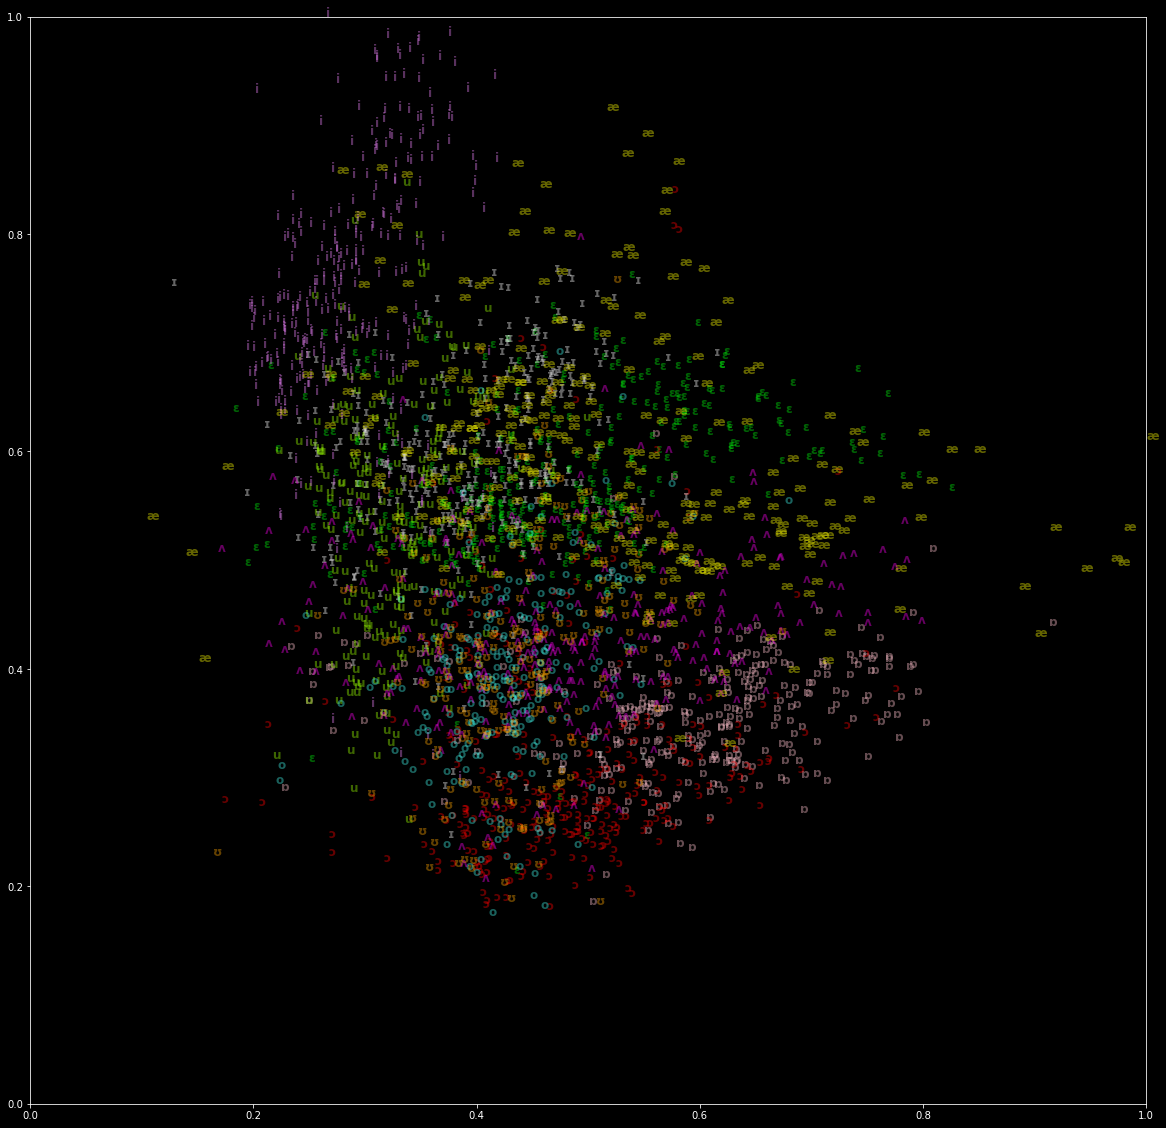

In [26]:
#x_min, x_max = np.min(df['F2'].values, 0), np.max(df['F2'].values, 0)
#df['F2'] = (df['F2'].values - x_min) / (x_max - x_min)

fig, ax = plt.subplots(figsize=(20,20))
plt.style.use('dark_background')
for i in range(len(df)):
        ax.text(df.iloc[i, 5]/max1, df.iloc[i, 6]/max2, 
                 str(df.Vowel.values[i]),
                 color=colors[str(df.Vowel.values[i])],
                 alpha=.4,
                 fontdict={'weight': 'bold', 'size': 12})

In [21]:
models = [("Random Forest", RandomForestClassifier()),
              ("Decision Tree", DecisionTreeClassifier()),
              ("kNN", KNeighborsClassifier()),
              ("Logistic", LogisticRegression()),
              ("Gradient Boosting", GradientBoostingClassifier())]

In [16]:
def get_data(item):
    data=item.drop(['Vowel','path','word'], axis=1)
    labels = item.Vowel
    le = LabelEncoder()
    y = le.fit_transform(labels)
    return data, y

In [17]:
model=RandomForestClassifier(random_state=1)
data, y = get_data(df)
X_train, X_test, y_train, y_test = train_test_split(data, y,random_state=1)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
score = accuracy_score(y_test, y_hat)
score

0.5975232198142415

In [53]:
gradientboost_grid = {'learning_rate': [.1, .5, .01, .001],
                      'n_estimators': [100, 150,300,500,1000],
                      'max_depth': [None, 2 ,3, 4, 5],
                      'random_state': [1]
                      }
                      

gb_gridsearch = RandomizedSearchCV(GradientBoostingClassifier(),
                            gradientboost_grid,
                            n_jobs=-1,
                            verbose=True,
                            scoring='accuracy')
gb_gridsearch.fit(X_train, y_train)

print ("best parameters:", gb_gridsearch.best_params_)

best_rf_model = gb_gridsearch.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best parameters: {'random_state': 1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}


In [54]:
best_rf_model

GradientBoostingClassifier(n_estimators=150, random_state=1)

In [19]:
def get_formants(soundfile_path, f):
	lst = []
	formant = parselmouth.Sound(soundfile_path).to_formant_burg()
	T = np.arange(formant.nt)*formant.dt + formant.t1
	form = [formant.get_value_at_time(f, t) for t in T]
	return form

In [20]:
path = "/Users/andrewargaez/Vowel_play/wav_files/ɒ/F/58/Lee/stock.wav"
x= get_formants(path,1)
y= get_formants(path,2)
snd = parselmouth.Sound(path)
formant = snd.to_formant_burg()
T = np.arange(formant.nt)*formant.dt + formant.t1
pch = snd.to_pitch_ac(time_step=formant.dt)
f0 = pch.selected_array["frequency"] 
form1 = [formant.get_value_at_time(1, t) for t in T]
form2 = [formant.get_value_at_time(2, t) for t in T]
ranch1 = np.array(form1)[f0[:len(form1)]>0]
ranch2 = np.array(form2)[f0[:len(form2)]>0]

In [33]:
print(ranch1.mean(), ranch2.mean())

1040.97532824472 1756.9748308310952


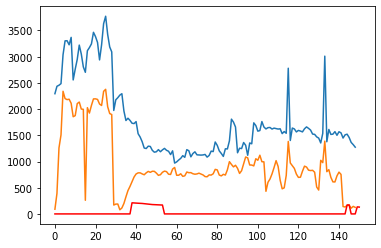

In [21]:
plt.plot(y)
plt.plot(x)
plt.plot(f0, c='red')